In [1]:
# All of your imports here (you may need to add some)
import numpy
import scipy
import pandas
from pandas import read_csv
import matplotlib.pylab as plot
import seaborn
#import kagglehub
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn import set_config
set_config(transform_output = "pandas")

# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled final model along with this notebook.

The group with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

Frame the Problem and Look at the Big Picture
=====================================
1. **Define the objective in business terms:** Predict if there will be a 5 day avg air above 40(max) above 32(min) and soil above 50 on or before april 1st
purchase before feb 25
2. **How will your solution be used?** We will make a prediction on feb 24
3. **How should you frame this problem?** This will be a supervised, classification problem. It will also be offline as it does not need to be constantly updated and can be updated annually.
4. **How should performance be measured? Is the performance measure aligned with the business objective?** Use F1 score to balance precision and recall to make sure early spring is as accurate as possible. Yes.
5. **What would be the minimum performance needed to reach the business objective?** Error should be near around 30 since the NWS is around that level of accuracy.
6. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** No personal comparable problems. Predicting the weather is similar to predicting an early spring.
7. **Is human expertise available?** National Weather Service is good at predicting and early spring and is around 70% accurate.
8. **How would you solve the problem manually?** Look at the historical patterns which led to an early spring and which did not and compare them to this year. See if the patterns for this year will meat the thresholds we set to determine an early spring.
9. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** We assume that the defined temperature thresholds (air max > 40°F, min temp > 32°F, soil > 50°F) are the correct conditions for determining early spring. We also assume historical patterns will hold true.

# Get the Data

1. **List the data you need and how much you need:**
- Soil data for every day from 1947
- Weather data for every day from 1947
- Phil's predictions(With some data missing)
- Early Spring(True or False)
2. **Find and document where you can get that data:**
- https://www.kaggle.com/datasets/groundhogclub/groundhog-day

3. **Get access authorizations**: None needed, publicy available.
- 

4. **Create a workspace**: This notebook.
5. **Get the data**: Given to us plus extra data found at <mark>STILL NEEDED</mark>
6. **Convert the data to a format you can easily manipulate**: Done, it's a CSV
7. **Ensure sensitive information is deleted or protected**: Done
8. **Check the size and type of data (time series, geographical, …)**: : 
   1. .

Do not look at the data too closely at this point since you have not yet split off the testing set. Basically, enough looking at it to understand *how* to split the test set off. It is likely you will have to review the website where the data came from to be able to understand some of the features.

In [2]:
def load_data(weather_filename="weather.csv", soil_filename="soil.csv", phil_pred_filename="phil_pred.csv", early_spring_filename="early_spring.csv", el_nino_filename="el_nino_data.csv"):
    """
    Load all the data and join it together. The data will be pivoted so that the year is the row index.
    Only years available in the data files will be included.
    
    Returns:
        pandas.DataFrame: A DataFrame with years as row indices.
    """
    # Load data from CSV files
    weather = pandas.read_csv(weather_filename, parse_dates=[0], na_values=['M'])
    soil = pandas.read_csv(soil_filename, parse_dates=[0])
    phil_pred = pandas.read_csv(phil_pred_filename)
    early_spring = pandas.read_csv(early_spring_filename)
    el_nino = pandas.read_csv(el_nino_filename)

    # Pivot and join data, using appropriate date columns for weather and soil
    basic_data = (
        pivot(weather, 'date')
        .join(pivot(soil, 'day'))
        .join(phil_pred.set_index('year'))
        .join(early_spring.set_index('year'))
        .join(el_nino.set_index('year'))
    )

    # Ensure all rows have matching years
    years = basic_data.index  # Get years from the data index
    return basic_data.loc[years]

def pivot(data, date_col, pivot_value='day_of_year'):
    """
    Pivot the data using the specified date column, setting the row index to 'year' and 
    column names based on the pivoted day, month, or week of the year.
    
    Args:
        data (pd.DataFrame): The data to pivot.
        date_col (str): The date column name to be used for year extraction.
        pivot_value (str): The attribute to pivot on (default 'day_of_year').
    
    Returns:
        pd.DataFrame: A pivoted DataFrame with years as index.
    """
    if date_col not in data.columns:
        raise KeyError(f"Date column '{date_col}' not found in the dataset. Available columns: {data.columns.tolist()}")

    data['year'] = data[date_col].dt.year
    data[pivot_value] = getattr(data[date_col].dt, pivot_value)
    data = data.drop(columns=[date_col]).pivot(index='year', columns=pivot_value)
    data.columns = ["_".join(str(x) for x in col) for col in data.columns.to_flat_index()]  # Flatten multi-index columns
    return data


In [3]:
data = load_data(weather_filename="weather.csv", soil_filename="soil.csv", phil_pred_filename="phil_pred.csv", early_spring_filename="early_spring.csv", el_nino_filename="el_nino_data.csv")


In [4]:
data.describe()

,max_temp_1,max_temp_2,max_temp_3,max_temp_4,max_temp_5,max_temp_6,max_temp_7,max_temp_8,max_temp_9,max_temp_10,...,max_soil_moisture_49,max_soil_moisture_50,max_soil_moisture_51,max_soil_moisture_52,max_soil_moisture_53,max_soil_moisture_54,max_soil_moisture_55,max_soil_moisture_56,jan_nino,feb_nino
count,70.000000,69.000000,69.000000,70.000000,70.000000,69.000000,68.000000,70.000000,69.000000,70.000000,...,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,66.000000,66.000000
mean,39.271429,39.057971,38.797101,38.428571,37.271429,36.521739,35.985294,34.842857,35.811594,35.428571,...,0.484643,0.485500,0.485143,0.488100,0.490243,0.487343,0.485671,0.483757,0.340909,0.206061
std,11.266111,10.181997,10.821520,13.200320,12.274542,10.325025,10.715441,12.849898,12.019929,11.889066,...,0.023101,0.024081,0.024224,0.022964,0.021784,0.022083,0.022025,0.021533,1.995300,2.186242
min,12.000000,12.000000,13.000000,9.000000,11.000000,8.000000,8.000000,2.000000,12.000000,8.000000,...,0.433000,0.432000,0.431000,0.431000,0.439000,0.440000,0.448000,0.440000,-5.800000,-6.000000
25%,33.000000,32.000000,32.000000,30.250000,31.000000,29.000000,30.000000,25.250000,25.000000,27.000000,...,0.469000,0.468250,0.466250,0.471000,0.476000,0.473000,0.469250,0.468250,-0.700000,-1.075000
50%,38.000000,38.000000,38.000000,36.500000,38.000000,35.000000,35.000000,34.000000,36.000000,36.000000,...,0.479000,0.477500,0.482500,0.487000,0.487500,0.486000,0.480000,0.479000,0.550000,0.300000
75%,44.750000,46.000000,46.000000,48.500000,43.750000,42.000000,41.000000,41.000000,44.000000,44.000000,...,0.505000,0.513000,0.507750,0.510500,0.515000,0.511250,0.507500,0.495750,1.800000,1.800000
max,70.000000,64.000000,64.000000,71.000000,66.000000,60.000000,64.000000,69.000000,67.000000,59.000000,...,0.520000,0.520000,0.520000,0.520000,0.520000,0.520000,0.520000,0.520000,4.000000,4.500000


In [5]:
spring = read_csv("early_spring.csv")
phil = read_csv("phil_pred.csv")
soil = read_csv("soil.csv")
weather = read_csv("weather.csv")
# https://www.cpc.ncep.noaa.gov/data/indices/soi
el_nino = read_csv("el_nino_data.csv")

In [6]:
weather['date'] = pandas.to_datetime(weather['date'])
soil['date'] = pandas.to_datetime(soil['day'])
X = weather.merge(soil.set_index("date"), on='date')
y = spring
X['year'] = X['date'].dt.year

In [7]:
phil_true = sum([1 for x in phil["prediction"] if x == True])
spring_true = sum([1 for x in spring["early_spring"] if x == True])
print("Phil True: ", phil_true)
print("Spring True: ", spring_true)
#from this we can see phil has significantly less true values than spring, and performs worse than a coin flip

Phil True:  14
Spring True:  35


In [8]:
X.head()


,date,max_temp,min_temp,avg_temp,precipitation,snowfall,snowdepth,day,mean_soil_temp,mean_soil_moisture,min_soil_temp,min_soil_moisture,max_soil_temp,max_soil_moisture,year
0,1947-01-01,30.0,24.0,27.0,0.12,0.5,1.0,1947-01-01,-3.220000,0.477200,-4.1,0.475,-1.4,0.480,1947
1,1947-01-02,44.0,29.0,36.5,0.49,0.0,0.0,1947-01-02,-2.533333,0.498333,-3.2,0.478,-1.8,0.518,1947
2,1947-01-03,54.0,41.0,47.5,0.04,0.0,M,1947-01-03,-1.733333,0.515000,-2.7,0.504,-0.1,0.519,1947
3,1947-01-04,42.0,24.0,33.0,0.0,0.0,M,1947-01-04,0.729167,0.496625,-0.1,0.489,2.1,0.509,1947
4,1947-01-05,33.0,25.0,29.0,0.0,0.0,M,1947-01-05,0.162500,0.485792,-0.7,0.484,1.1,0.489,1947


In [9]:
#X.value_counts()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3920 non-null   datetime64[ns]
 1   max_temp            3920 non-null   object        
 2   min_temp            3920 non-null   object        
 3   avg_temp            3920 non-null   object        
 4   precipitation       3920 non-null   object        
 5   snowfall            3920 non-null   object        
 6   snowdepth           3920 non-null   object        
 7   day                 3920 non-null   object        
 8   mean_soil_temp      3920 non-null   float64       
 9   mean_soil_moisture  3920 non-null   float64       
 10  min_soil_temp       3920 non-null   float64       
 11  min_soil_moisture   3920 non-null   float64       
 12  max_soil_temp       3920 non-null   float64       
 13  max_soil_moisture   3920 non-null   float64     

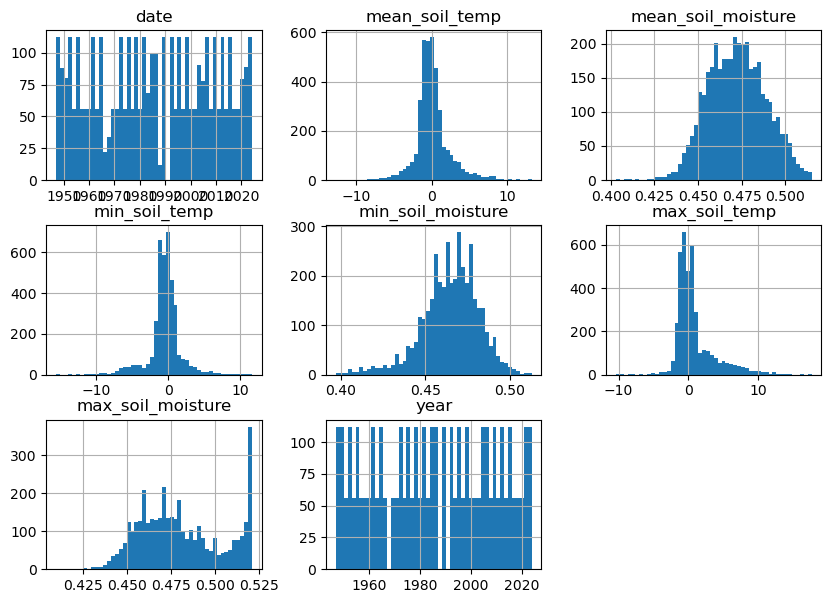

In [10]:
X_filtered = X.copy()
X_filtered.hist(bins=50, figsize=(10,7));
#Just using febuary data, as it is the month of the prediction, and the data seems more normal.

### Just using febuary data, as it is the month of the prediction, and the data seems more normal.
- Mean soil Moisture= Normal Distribution
- Min Soil Moisture = Normal Distribution
- Min Temp = Normal Distribution
- Max soil temp = Left Skewed(Tested with Log, not Log Normal)
- Max Soil Moisutre = Normal



In [11]:
#filtered_X = filtered_X[filtered_X["max_soil_moisture"] < 100]
#filtered_X["max_soil_moisture"].hist(bins=50, figsize=(10,5))

<Axes: >

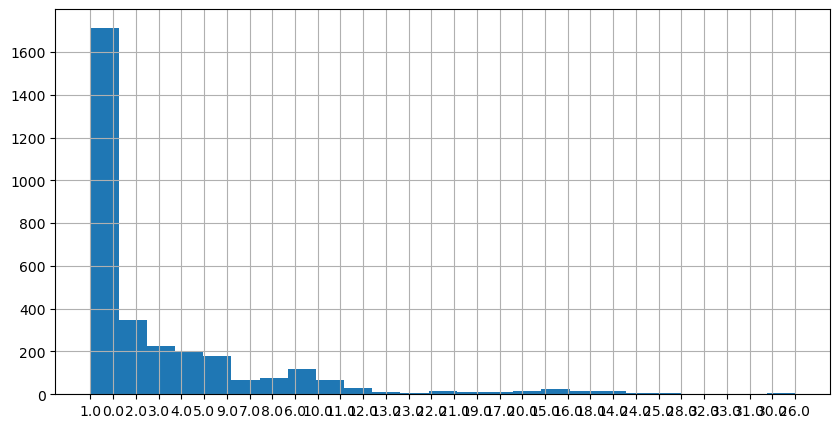

In [12]:
X["snowdepth"].value_counts()
X_filtered = X.copy()
# remove T and M values
X_filtered = X_filtered[X_filtered["snowdepth"] != "T"]
X_filtered = X_filtered[X_filtered["snowdepth"] != "M"]
X_filtered["snowdepth"].hist(bins=25, figsize=(10,5))


Do not know what M and T stand for: should ask farmer Jeff.

In [13]:
X["snowfall"].value_counts()

snowfall
0.0     2101
T        666
1.0      223
0.5      206
2.0      105
        ... 
7.5        1
4.1        1
12.0       1
3.7        1
4.4        1
Name: count, Length: 69, dtype: int64

<Axes: >

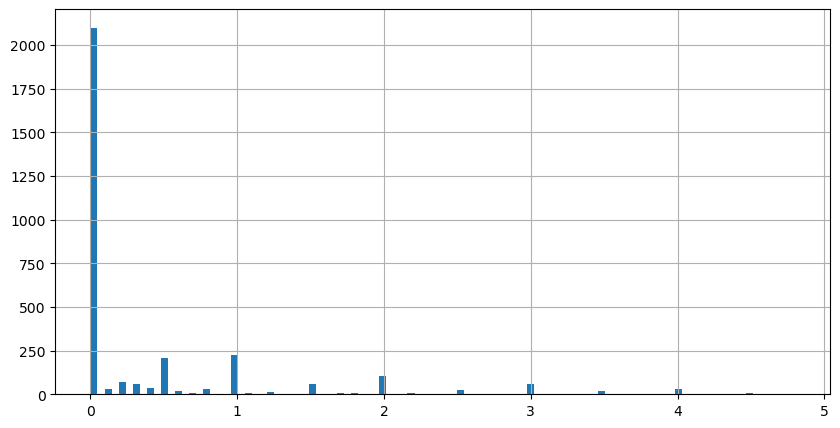

In [14]:

X_filtered = X.copy()
# remove T and M values
X_filtered = X_filtered[X_filtered["snowfall"] != "T"]
X_filtered = X_filtered[X_filtered["snowfall"] != "M"]
X_filtered["snowfall"] = X_filtered["snowfall"].astype(float)

X_filtered = X_filtered[X_filtered["snowfall"] < 5]
X_filtered["snowfall"].hist(bins=100, figsize=(10,5))

- Again with the M and Ts
- Not very continuous
- Very left skewed

<Axes: >

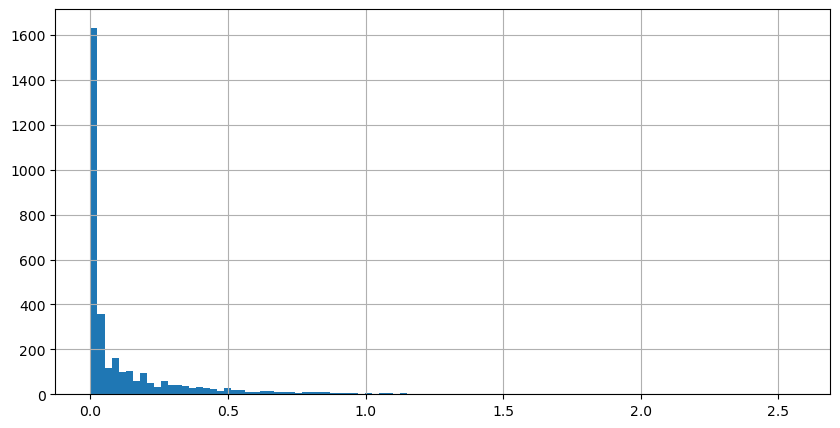

In [15]:
X_filtered = X.copy()
# remove T and M values
X_filtered = X_filtered[X_filtered["precipitation"] != "T"]
X_filtered = X_filtered[X_filtered["precipitation"] != "M"]
X_filtered["precipitation"] = X_filtered["precipitation"].astype(float)
X_filtered["precipitation"].hist(bins=100, figsize=(10,5))

- Again with the M and Ts
- Looks like a log

Explore the Data
========

1. **Copy the data for exploration, downsampling to a manageable size if necessary:** already small enough.
2. **Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …):** <mark>TODO</mark> - complete in the cells below
3. **For supervised learning tasks, identify the target attribute(s):** <mark>TODO</mark>
4. **Visualize the data:** <mark>TODO</mark> - complete in the cells below
5. **Study the correlations between attributes:** <mark>TODO</mark> - complete in the cells below
6. **Study how you would solve the problem manually:** <mark>TODO</mark>
7. **Identify the promising transformations you may want to apply:** <mark>TODO</mark> - complete in the cells below
8. **Identify extra data that would be useful (go back to “Get the Data”):** <mark>TODO</mark> - complete in the cells below
9. **Document what you have learned:** <mark>TODO</mark> - last cell in this section

In [16]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3283 entries, 0 to 3919
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3283 non-null   datetime64[ns]
 1   max_temp            3283 non-null   object        
 2   min_temp            3283 non-null   object        
 3   avg_temp            3283 non-null   object        
 4   precipitation       3283 non-null   float64       
 5   snowfall            3283 non-null   object        
 6   snowdepth           3283 non-null   object        
 7   day                 3283 non-null   object        
 8   mean_soil_temp      3283 non-null   float64       
 9   mean_soil_moisture  3283 non-null   float64       
 10  min_soil_temp       3283 non-null   float64       
 11  min_soil_moisture   3283 non-null   float64       
 12  max_soil_temp       3283 non-null   float64       
 13  max_soil_moisture   3283 non-null   float64       
 1

<Axes: >

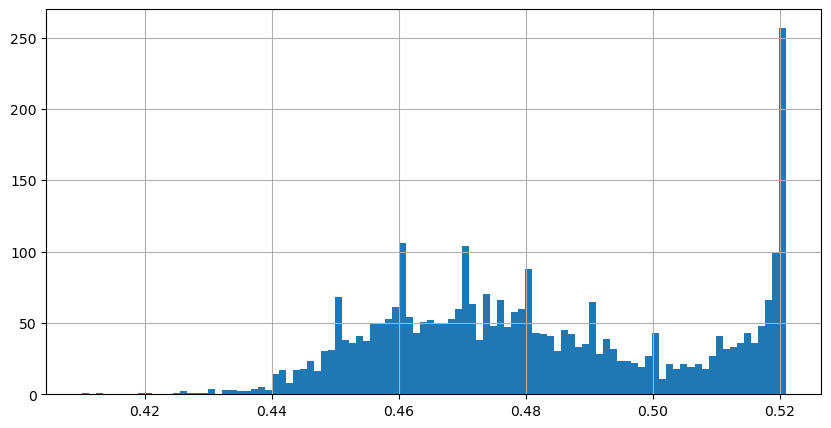

In [17]:
X_filtered["max_soil_moisture"].hist(bins=100, figsize=(10,5))

<Axes: >

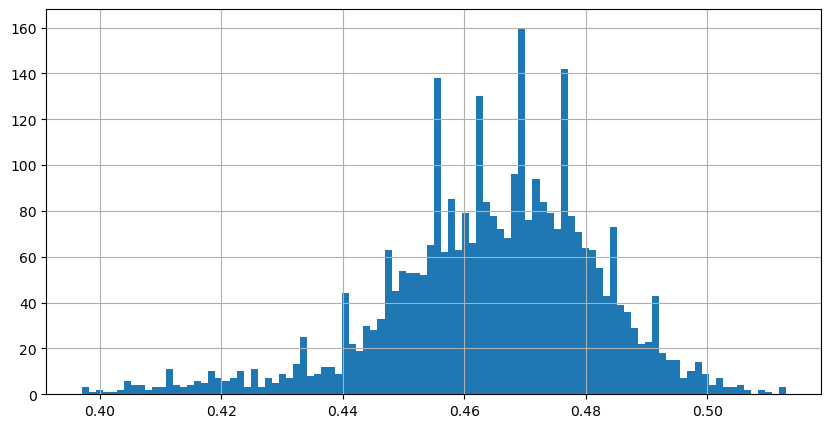

In [18]:
X_filtered["min_soil_moisture"].hist(bins=100, figsize=(10,5))

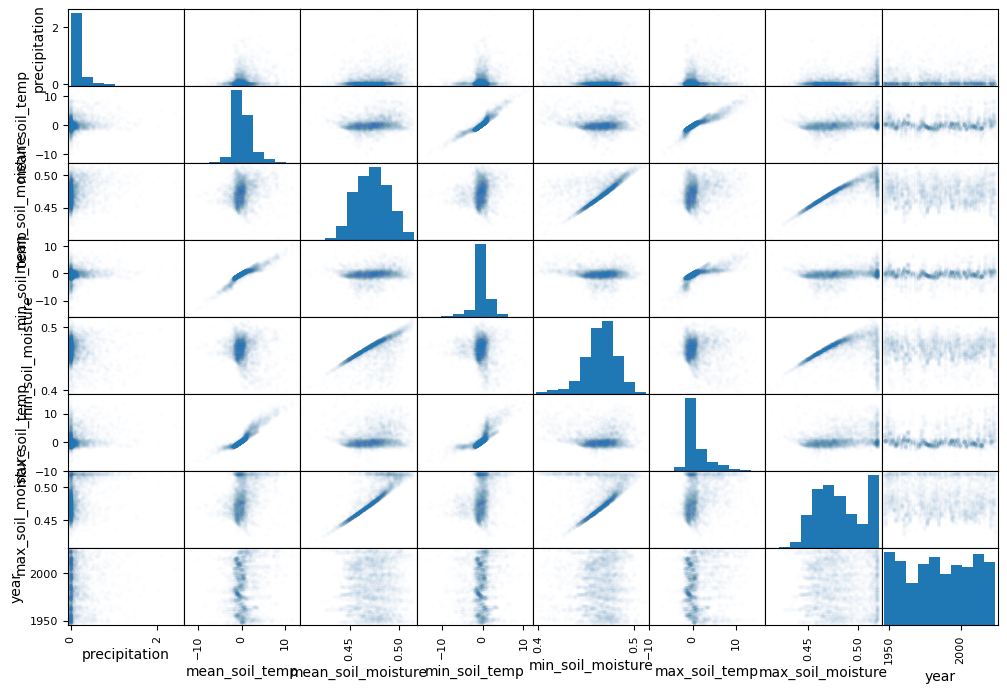

In [19]:
pandas.plotting.scatter_matrix(X_filtered, alpha=0.01, figsize=(12, 8));

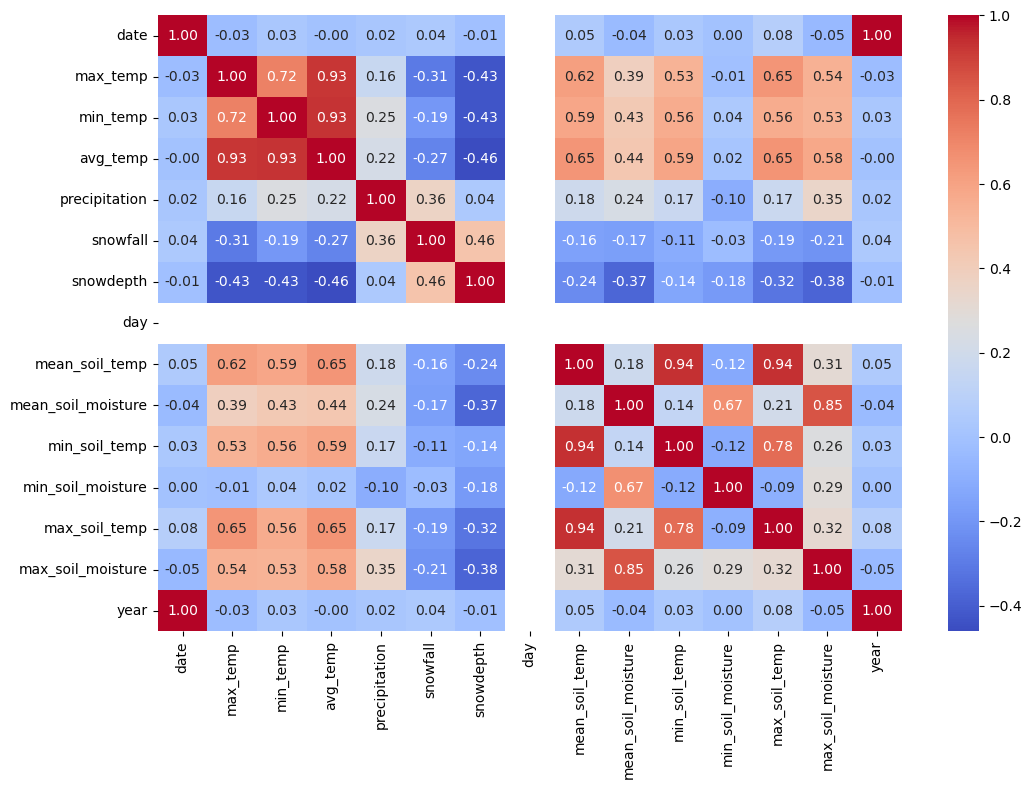

In [20]:
# Remove non-numeric values
X_filtered = X_filtered.apply(pandas.to_numeric, errors='coerce')
X_filtered.corr()
plot.figure(figsize=(12, 8))
seaborn.heatmap(X_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plot.xticks(fontsize=10)
plot.yticks(fontsize=10)
plot.show()

In [21]:
el_nino.columns

Index(['year', 'jan_nino', 'feb_nino'], dtype='object')

In [22]:
X_filtered = X_filtered.join(el_nino.set_index("year"), on="year")
X_filtered

,date,max_temp,min_temp,avg_temp,precipitation,snowfall,snowdepth,day,mean_soil_temp,mean_soil_moisture,min_soil_temp,min_soil_moisture,max_soil_temp,max_soil_moisture,year,jan_nino,feb_nino
0,-725846400000000000,30.0,24.0,27.0,0.12,0.5,1.0,NaN,-3.220000,0.477200,-4.1,0.475,-1.4,0.480,1947,NaN,NaN
1,-725760000000000000,44.0,29.0,36.5,0.49,0.0,0.0,NaN,-2.533333,0.498333,-3.2,0.478,-1.8,0.518,1947,NaN,NaN
2,-725673600000000000,54.0,41.0,47.5,0.04,0.0,NaN,NaN,-1.733333,0.515000,-2.7,0.504,-0.1,0.519,1947,NaN,NaN
3,-725587200000000000,42.0,24.0,33.0,0.00,0.0,NaN,NaN,0.729167,0.496625,-0.1,0.489,2.1,0.509,1947,NaN,NaN
4,-725500800000000000,33.0,25.0,29.0,0.00,0.0,NaN,NaN,0.162500,0.485792,-0.7,0.484,1.1,0.489,1947,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,1708473600000000000,49.0,15.0,32.0,0.00,0.0,0.0,NaN,0.766667,0.428458,-0.4,0.423,4.5,0.431,2024,0.8,-2.3
3916,1708560000000000000,55.0,24.0,39.5,0.00,0.0,0.0,NaN,2.770833,0.436958,1.1,0.423,4.8,0.486,2024,0.8,-2.3
3917,1708646400000000000,46.0,36.0,41.0,0.53,0.0,0.0,NaN,3.412500,0.491792,1.1,0.475,6.8,0.516,2024,0.8,-2.3
3918,1708732800000000000,55.0,28.0,41.5,0.00,0.0,0.0,NaN,1.645833,0.472458,0.6,0.462,5.2,0.480,2024,0.8,-2.3


In [23]:
X_filtered = X_filtered.drop(columns=["date", "year","snowdepth", "snowfall", "precipitation", "max_soil_moisture", "min_soil_moisture"])
X_filtered = X_filtered.apply(pandas.to_numeric, errors='coerce')

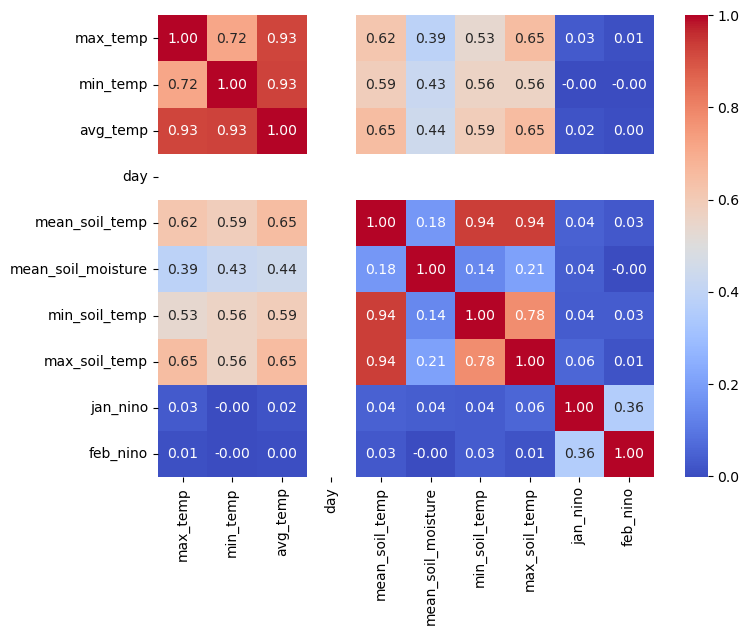

In [24]:
X_filtered.corr()
plot.figure(figsize=(8, 6))
seaborn.heatmap(X_filtered.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plot.xticks(fontsize=10)
plot.yticks(fontsize=10)
plot.show()

<Axes: >

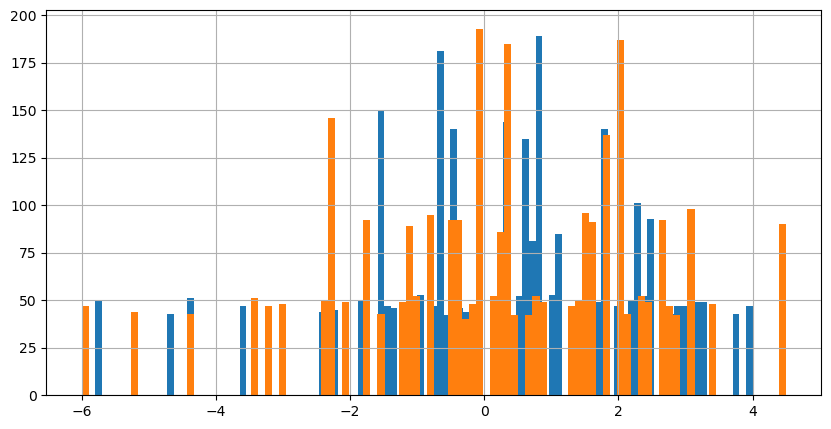

In [25]:
# bar graph of feb nino and jan nino
X_filtered["jan_nino"].hist(bins=100, figsize=(10,5))
X_filtered["feb_nino"].hist(bins=100, figsize=(10,5))


- not most continous data 

In [26]:
# data is made to have (row * days / year) column
import pandas as pd


if "date" in X.columns:
    X['date'] = pd.to_datetime(X['date'])  # Ensure 'date' is in datetime format
    X.join(el_nino.set_index("year"), on="year")
    X['day_of_year'] = X.date.dt.dayofyear
    X = X.drop(columns=["date"]).pivot(index=['year'], columns=['day_of_year'])
    X.columns = ["_".join(str(x) for x in i) for i in X.columns.to_flat_index()]


In [27]:
X

,max_temp_1,max_temp_2,max_temp_3,max_temp_4,max_temp_5,max_temp_6,max_temp_7,max_temp_8,max_temp_9,max_temp_10,...,max_soil_moisture_47,max_soil_moisture_48,max_soil_moisture_49,max_soil_moisture_50,max_soil_moisture_51,max_soil_moisture_52,max_soil_moisture_53,max_soil_moisture_54,max_soil_moisture_55,max_soil_moisture_56
year,,,,,,,,,,,,,,,,,,,,,
1947,30.0,44.0,54.0,42.0,33.0,33.0,34.0,35.0,31.0,30.0,...,0.492,0.475,0.474,0.469,0.466,0.465,0.464,0.462,0.460,0.458
1948,46.0,41.0,32.0,34.0,34.0,32.0,32.0,41.0,49.0,33.0,...,0.515,0.517,0.518,0.519,0.516,0.488,0.482,0.476,0.473,0.506
1949,31.0,34.0,40.0,43.0,55.0,54.0,49.0,56.0,61.0,53.0,...,0.503,0.486,0.477,0.469,0.517,0.491,0.515,0.501,0.485,0.511
1950,49.0,53.0,61.0,69.0,54.0,53.0,43.0,30.0,48.0,59.0,...,0.501,0.484,0.476,0.474,0.469,0.466,0.518,0.495,0.480,0.478
1951,40.0,46.0,52.0,50.0,41.0,46.0,36.0,23.0,30.0,46.0,...,0.484,0.512,0.505,0.519,0.506,0.519,0.493,0.477,0.469,0.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,39.0,37.0,49.0,50.0,47.0,37.0,41.0,34.0,33.0,39.0,...,0.478,0.472,0.513,0.506,0.479,0.473,0.470,0.463,0.463,0.472
2021,33.0,49.0,50.0,40.0,35.0,34.0,35.0,35.0,32.0,34.0,...,0.517,0.490,0.477,0.471,0.467,0.464,0.486,0.512,0.520,0.518
2022,56.0,53.0,45.0,29.0,39.0,48.0,26.0,19.0,34.0,42.0,...,0.476,0.519,0.519,0.490,0.482,0.476,0.520,0.509,0.493,0.514


In [28]:
class FillInMissing(BaseEstimator, TransformerMixin):
    def __init__(self, fillIns):
        self.fillIns = fillIns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for col in self.fillIns:
            X[col] = X[col].replace("T", .05)
            X[col] = X[col].replace("M", numpy.nan)
            X[col] = X[col].astype(float)
        return X
    

In [29]:
# not finished yet
MTfillIns = ['precipitation', 'snowdepth', 'snowfall']

class FillInMissing(BaseEstimator, TransformerMixin):
    def __init__(self, fillIns):
        self.fillIns = fillIns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for col in self.fillIns:
            X[col] = X[col].replace("T", .05)
            X[col] = X[col].replace("M", numpy.nan)
            X[col] = X[col].astype(float)
        return X

Pipeline(steps=[
    ('TMfillin', FillInMissing(MTfillIns)), # fill in T and M values
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('OHE', OneHotEncoder())
])


Pipeline(steps=[('TMfillin',
                 FillInMissing(fillIns=['precipitation', 'snowdepth',
                                        'snowfall'])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('OHE', OneHotEncoder())])

In [36]:
# Example loading data function, adjust as needed for your case
data = load_data()  # Assuming load_data() loads and returns a DataFrame as per your function

# Splitting into features and target
X = data.drop(columns='early_spring')  # Assuming 'early_spring' is the target
y = data['early_spring']

# Custom function for date extraction
def extract_date_features(X):
    X = X.copy()
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['day_of_year'] = X['date'].dt.dayofyear
    return X.drop(columns=['date'])

# Preprocessing pipeline
date_transformer = FunctionTransformer(extract_date_features)
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = StandardScaler()

# Setting up column categories for the transformers
date_cols = ['date']
categorical_cols = ['T_or_F']  # Add other categorical columns as needed
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols + date_cols)

# Column transformer to handle different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('date', date_transformer, date_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('num', scaler, numeric_cols)
    ],
    remainder='drop'  # Drop other columns not specified here
)

# Final pipeline
# Ensure the columns specified in the ColumnTransformer exist in the DataFrame
date_cols = ['date'] if 'date' in X.columns else []
categorical_cols = ['T_or_F'] if 'T_or_F' in X.columns else []
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_cols + date_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ('date', date_transformer, date_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                          ('scaler', StandardScaler())
                          ]), numeric_cols)
    ],
    remainder='drop'  # Drop other columns not specified here
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Replace with your chosen classifier
])

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.replace("NaN", 0)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1: {f1:.4f}')



Accuracy: 0.7143
Precision: 0.7083
Recall: 0.7143
F1: 0.7143
